In [53]:
from __future__ import division

import numpy as np
import glob, os, json, argparse
import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

import arviz as az
import warnings
warnings.filterwarnings('ignore')

import enterprise_extensions
from enterprise_extensions import models, model_utils, timing
from enterprise_extensions import sampler as ee_sampler

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# timing model delay
@signal_base.function
def tm_delay(t2pulsar, param_dict, parfile_vals, parfile_errs, 
             pos_params, pm_params, spin_params, kep_params):
    """
    Compute difference in residuals due to perturbed timing model.
    :param residuals: original pulsar residuals from Pulsar object
    :param t2pulsar: libstempo pulsar object
    :return: difference between new and old residuals in seconds
    """

    residuals = t2pulsar.residuals()

    # set to new values
    new_params = {}

    pos_params_rescaled = (pos_params * np.array([parfile_errs[p] for p in param_dict['pos']]) 
                           + np.array([parfile_vals[p] for p in param_dict['pos']]))

    for p,v in zip(param_dict['pos'], pos_params_rescaled):
        new_params.update({p: v})

    pm_params_rescaled = (pm_params * np.array([parfile_errs[p] for p in param_dict['pm']]) 
                       + np.array([parfile_vals[p] for p in param_dict['pm']]))
    
    for p,v in zip(param_dict['pm'], pm_params_rescaled):
        new_params.update({p: v})
    
    spin_params_rescaled = (spin_params * np.array([parfile_errs[p] for p in param_dict['spin']]) 
                           + np.array([parfile_vals[p] for p in param_dict['spin']]))

    for p,v in zip(param_dict['spin'], spin_params_rescaled):
        new_params.update({p: v})

    kep_params_rescaled = (kep_params * np.array([parfile_errs[p] for p in param_dict['kep']]) 
                           + np.array([parfile_vals[p] for p in param_dict['kep']]))

    for p,v in zip(param_dict['kep'], kep_params_rescaled):
        new_params.update({p: v})

    t2pulsar.vals(new_params)
    new_res = t2pulsar.residuals()

    # remmeber to set values back to originals
    t2pulsar.vals(parfile_vals)

    # Return the time-series for the pulsar
    return new_res - residuals

In [6]:
#partimdir = '/Users/Sarah/Documents/Research/NANOGrav/nanograv_data/5yr/partim/'
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

partimdir = top_dir + '/5yr/NANOGrav_dfg+12_20120911/'
psrname = 'J2317+1439'

psr = Pulsar(partimdir + 'par/' + psrname + '_NANOGrav_dfg+12.par', 
             partimdir + 'tim/' + psrname + '_NANOGrav_dfg+12.tim', drop_t2pulsar=False)

In [8]:
param_dict = {}

# get position parameters from par file
if 'RAJ' and 'DECJ' in psr.t2pulsar.pars():
    param_dict.update({'pos': ['RAJ', 'DECJ']})
elif 'ELONG' and 'ELAT' in psr.t2pular.pars():
    param_dict.update({'pos': ['ELONG', 'ELAT']})
else:
    print('I couldn\'t find the position parameters!')
    param_dict.update({'pos': None})
    
param_dict.update({'pm': [p for p in psr.t2pulsar.pars() if 'PM' in p]})

param_dict.update({'spin': [p for p in psr.t2pulsar.pars() if 'F' in p]})

kep_params = ['PB', 'T0', 'A1', 'OM', 'ECC']
param_dict.update({'kep': [p for p in psr.t2pulsar.pars() if p in kep_params]})
if len(param_dict['kep']) > 5:
    print('Something is wrong! There are more than 5 Keplerian binary parameters!')

In [9]:
# create dictionaries with the parameter values and errors from the par files
parfile_vals = dict(zip(psr.t2pulsar.pars(), psr.t2pulsar.vals()))
parfile_errs = dict(zip(psr.t2pulsar.pars(), psr.t2pulsar.errs()))

In [10]:
# default 3-sigma prior above and below the parfile mean
pos_params = parameter.Normal(0., 3.0, size=len(param_dict['pos']))
pm_params = parameter.Normal(0., 3.0, size=len(param_dict['pm']))
spin_params = parameter.Normal(0., 3.0, size=len(param_dict['spin']))
kep_params = parameter.Normal(0., 3.0, size=len(param_dict['kep']))

# timing model
tm_func = tm_delay(param_dict=param_dict, parfile_vals=parfile_vals, parfile_errs=parfile_errs, 
                   pos_params=pos_params, pm_params=pm_params, spin_params=spin_params, 
                   kep_params=kep_params)
s = deterministic_signals.Deterministic(tm_func, name='timing_model')
    
# first combine all of the pulsar noise terms
s += models.white_noise_block(vary=True, inc_ecorr=False, select='backend')
#s += models.red_noise_block(prior='log-uniform', components=30)

In [11]:
# initialize PTA
model = [s(psr)]
pta = signal_base.PTA(model)

In [12]:
# dimension of parameter space
params = pta.param_names
ndim = len(params)
print(params)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)

# parameter groupings
groups = ee_sampler.get_parameter_groups(pta)

# add more parameter groupings for timing model parameters
for signal in param_dict.keys():
    groups.append([params.index(p) for p in params if signal in str(p)])

outdir = 'chains/nonlineartiming/'
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir=outdir, resume=False)
np.savetxt(outdir+'/pars.txt',
               list(map(str, pta.param_names)), fmt='%s')
np.savetxt(outdir+'/priors.txt',
               list(map(lambda x: str(x.__repr__()), pta.params)), fmt='%s')

# additional jump proposals
jp = ee_sampler.JumpProposal(pta)

# always add draw from prior
sampler.addProposalToCycle(jp.draw_from_prior, 5)

# Red noise prior draw
if 'red noise' in jp.snames:
    print('Adding red noise prior draws...\n')
    sampler.addProposalToCycle(jp.draw_from_red_prior, 10)

['2317+1439_327G_ASP_efac', '2317+1439_327G_ASP_log10_equad', '2317+1439_430G_ASP_efac', '2317+1439_430G_ASP_log10_equad', '2317+1439_timing_model_kep_params_0', '2317+1439_timing_model_kep_params_1', '2317+1439_timing_model_pm_params_0', '2317+1439_timing_model_pm_params_1', '2317+1439_timing_model_pos_params_0', '2317+1439_timing_model_pos_params_1', '2317+1439_timing_model_spin_params_0', '2317+1439_timing_model_spin_params_1']


In [13]:
x0 = np.hstack([p.sample() for p in pta.params])

In [14]:
for i,p in enumerate(pta.param_names):
    if 'timing' in p:
        x0[i] = 0
    elif 'efac' in p:
        x0[i] = 1
print(x0)

[ 1.         -5.25745029  1.         -7.67607591  0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [15]:
N = 50000
sampler.sample(x0, N, AMweight=25, SCAMweight=40, DEweight=55)

/Users/andrewkaiser/anaconda3/envs/enterprise/lib/python3.6/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 20.00 percent in 41.956760 s Acceptance rate = 0.440989Adding DE jump with weight 55
Finished 98.00 percent in 203.250014 s Acceptance rate = 0.428286
Run Complete


In [16]:
params = list(np.loadtxt('chains/nonlineartiming/pars.txt', dtype='S42', delimiter='z'))
chain = np.loadtxt('chains/nonlineartiming/chain_1.txt')

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

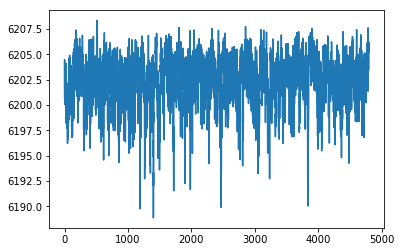

In [19]:
plt.plot(chain[100:,-4])

In [49]:
names = pta.param_names+['lnlike','lnprior', 'chain_accept', 'pt_chain_accept']
chain_dict = {}
for i,par in enumerate(names):
    chain_dict[par] = chain[:,i]
az_chains = az.convert_to_inference_data(chain_dict)

In [51]:
print(az_chains.posterior)

<xarray.Dataset>
Dimensions:                               (chain: 1, draw: 4900)
Coordinates:
  * chain                                 (chain) int64 0
  * draw                                  (draw) int64 0 1 2 ... 4897 4898 4899
Data variables:
    2317+1439_327G_ASP_efac               (chain, draw) float64 1.0 ... 0.9474
    2317+1439_327G_ASP_log10_equad        (chain, draw) float64 -5.257 ... -6.313
    2317+1439_430G_ASP_efac               (chain, draw) float64 1.0 ... 1.453
    2317+1439_430G_ASP_log10_equad        (chain, draw) float64 -7.676 ... -6.553
    2317+1439_timing_model_kep_params_0   (chain, draw) float64 0.0 ... 0.2528
    2317+1439_timing_model_kep_params_1   (chain, draw) float64 0.0 ... -0.4188
    2317+1439_timing_model_pm_params_0    (chain, draw) float64 0.0 ... -0.05278
    2317+1439_timing_model_pm_params_1    (chain, draw) float64 0.0 ... 0.3157
    2317+1439_timing_model_pos_params_0   (chain, draw) float64 0.0 ... 0.8796
    2317+1439_timing_model_pos_p

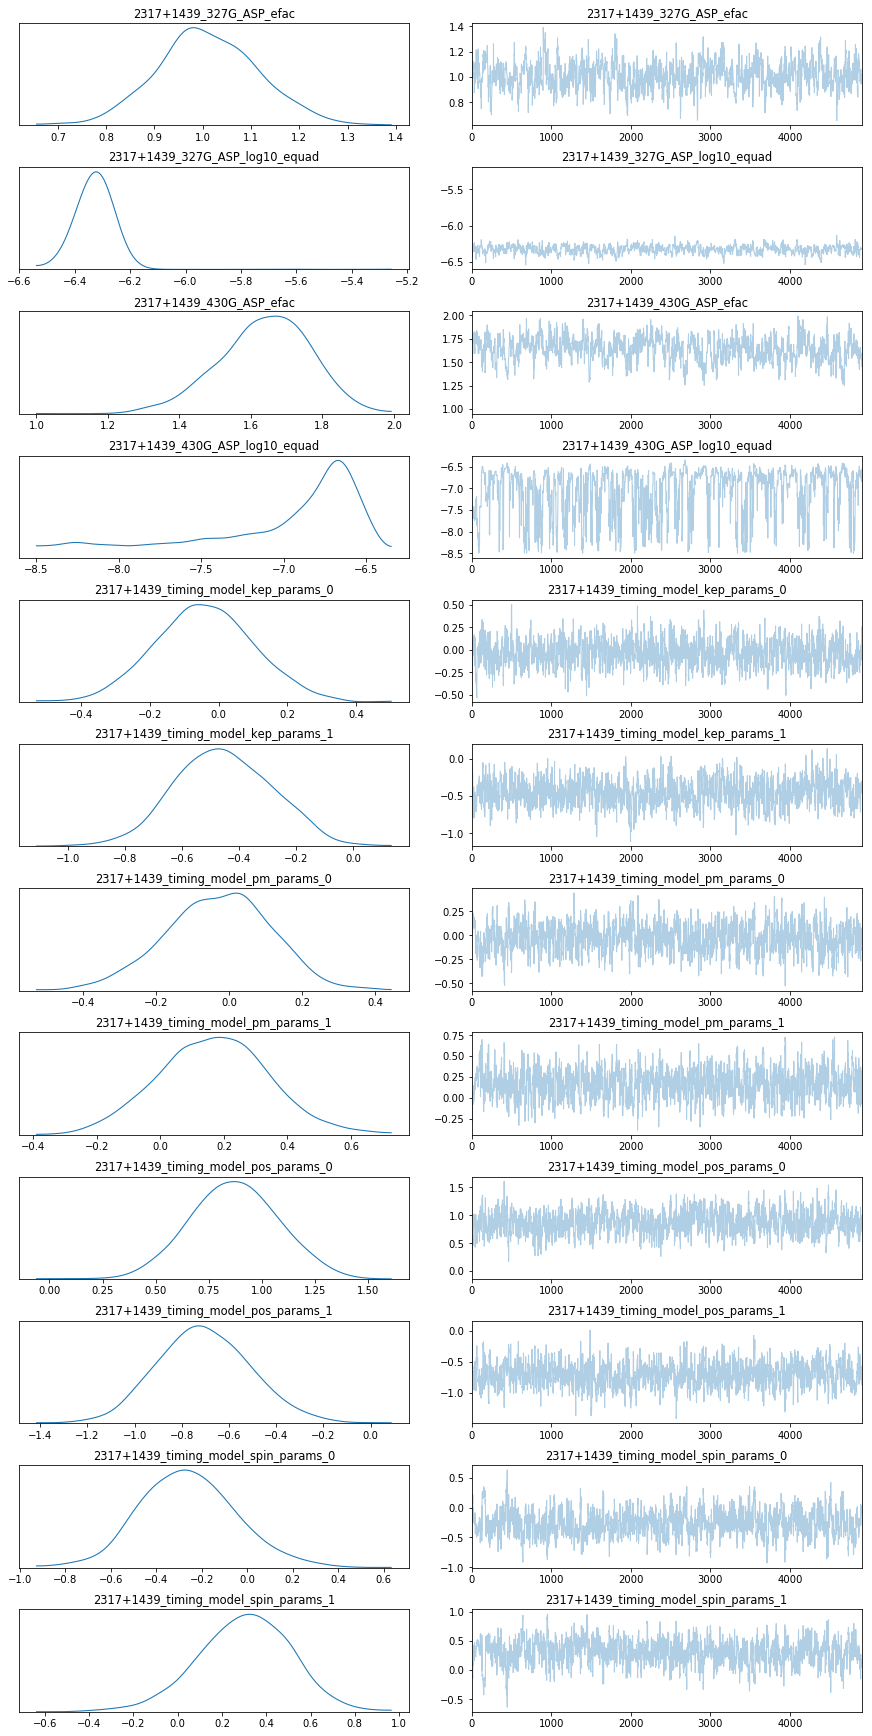

In [55]:
az.plot_trace(az_chains,var_names=pta.param_names);